---
layout: page
title: TSLA Tesla Ark Invest Price Targets
---

In [10]:
""" import library and package dependencies """
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pytz
from collections import namedtuple
from urllib.parse import quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from IPython.display import display, Markdown

from data_loader import load_data
from chart_format import StandardChart, LogChart, PercentileChart

In mid 2018 TSLA was trading around $240 a share and Musks' infamous "funding secured" tweet that considered a potential buy back at $420 per share may seem a reasonably strong 2x return on investment. 

Soon after on 22 August 2018, Ark Invest CEO Cathy Woods published a blog titled "[Dear Elon: An Open Letter Against Taking Tesla Private](https://ark-invest.com/articles/analyst-research/tesla-private/)" in which Cathy explained the enormous disruptive growth potential over a long term (four year) time horizon.

Ark Invest's research and modeling forecast a bear, base and bull case scenario that suggest a four year price target somewhere between $700 and $4,000; significantly higher than the suggested $420 offer price, and subsequently a huge financial loss to investors should Tesla become a private company before these forecast gains are realized. 

Thankfully for all investors, Tesla remained a public company and ARK Invest continue to publish research on disruptive innovation. 

Ark Invest update and publish their four year price targets every year, usually around mid-April.

In [11]:
df_tsla = pd.DataFrame()
# Restore dataframe from previous notebook
%store -r df_tsla

In [12]:
""" Load data """
# Given price targets data is manually collected it is easier to use a markdown table than csv file
csv_file = '../data/tsla_PriceTargets.md'
# Read markdown table as csv format with '|' as separator and skip the row of '----' separators
df_targets = pd.read_csv('../data/tsla_PriceTargets.md', sep='|', skipinitialspace=True, skiprows=[1])
# Drop the first and last (empty) columns due to how the markdown table is imported
df_targets = df_targets.iloc[:, 1:-1]  
# Remove leading/trailing white spaces from column names
df_targets.columns = df_targets.columns.str.strip()
# Remove leading/trailing white spaces from data
df_targets = df_targets.map(lambda x: x.strip() if isinstance(x, str) else x)

In [13]:
""" Data Transformation """
df_targets['Date'] = pd.to_datetime(df_targets['TargetDate'],dayfirst=True)
df_targets['ForecastDate'] = pd.to_datetime(df_targets['ForecastDate'],dayfirst=True)
df_targets.set_index('Date', inplace=True)
df_targets = df_targets.sort_index()

In [14]:
""" Adjust price targets for stock splits """
def adjust_price(row, date, multiplier):
    if row['ForecastDate'] < pd.to_datetime(date):
        row['Bear'] = (row['Bear'] / multiplier)
        row['Base'] = (row['Base'] / multiplier)
        row['Bull'] = (row['Bull'] / multiplier)
    return row

df_targets_pre_split = df_targets.copy()
# 5-for-1 price split
df_targets = df_targets.apply(adjust_price, args=('2020-08-28', 5), axis=1)
# 3-for-1 price split
df_targets = df_targets.apply(adjust_price, args=('2022-08-25', 3), axis=1)


In [15]:
colors = {}
colors['tsla']='#3f77e4'
colors['ark']={
    'bear': 'darkorange',
    'base': '#888888',
    'bull': 'orange',
}
colors['other']=[
    'mediumseagreen',#'#3CB371',
    'olivedrab',#'#6B8E23',
    'green',#'#008000',
    'darkgreen',#'#006400',
    'mediumseagreen',#'#3CB371',
    'darkseagreen',#'#8FBC8F',
    'limegreen',#'#32CD32',
    'seagreen',#'#2E8B57',
    'forestgreen',#'#228B22',
    'yellowgreen',#'#9ACD32',
    'darkolivegreen',#'#556B2F',
    'olive',#'#808000',

    'springgreen',#'#00FF7F',
    'mediumspringgreen',#'#00FA9A',

    # light green colors
    'lightgreen',#'#90EE90',
    'palegreen',#'#98FB98',

    # bright green colors
    'greenyellow',#'#ADFF2F',
    'lawngreen',#'#7CFC00',
    'lime',#'#00FF00',
]

In mid 2018 TSLA was trading around $240 a share, and the Ark Invest 2023 price targets of somewhere between $700 and $4,000 seemed ridiculous. To many 'expert' financial analysts this was simply not possible for an auto manufacturer.

The ongoing Ark Invest four year price targets may still seem ridiculous to many 'expert' finanical analysts, especially when plot on a standard chart with the TSLA price targets split adjusted to current prices:

In [16]:
def plot_ark_forecast(plt, df_targets):
    name=['']
    name[0] = 'ARKInvest'
    line_color = {
        'bear': 'darkorange',
        'base': '#888888',
        'bull': 'orange',
    }
    line_alpha = 0.9
    line_width = 1.5
    df_ark = df_targets[df_targets['Source'] == 'ARKInvest']
                
    # Plot rolling ongoing forecast eg 4 year forecast updated each year
    rolling_forecast = df_ark.drop_duplicates(subset=['ForecastDate'])
    if len(rolling_forecast) > 1:
        #if group['Bear'].notna().sum() > 1:
        plt.plot(rolling_forecast.index, rolling_forecast['Bear'], marker='.', label=name[0]+' Bear', color=line_color['bear'], alpha=line_alpha)
        #if group['Base'].notna().sum() > 1:
        plt.plot(rolling_forecast.index, rolling_forecast['Base'], marker='.', label=name[0], color=line_color['base'], alpha=line_alpha)
        #if group['Bull'].notna().sum() > 1:
        plt.plot(rolling_forecast.index, rolling_forecast['Bull'], marker='.', label=name[0]+' Bull', color=line_color['bull'], alpha=line_alpha)   

    # plot actual price data last, so I can see it over the top of the target lines.
    plt.plot(df_tsla.index, df_tsla[data_column], color=colors[0]['color'], label='TSLA Actual')

    right_limit = rolling_forecast.last_valid_index() + pd.offsets.YearBegin(1)   
    plt.xlim(right=right_limit)     
    return plt

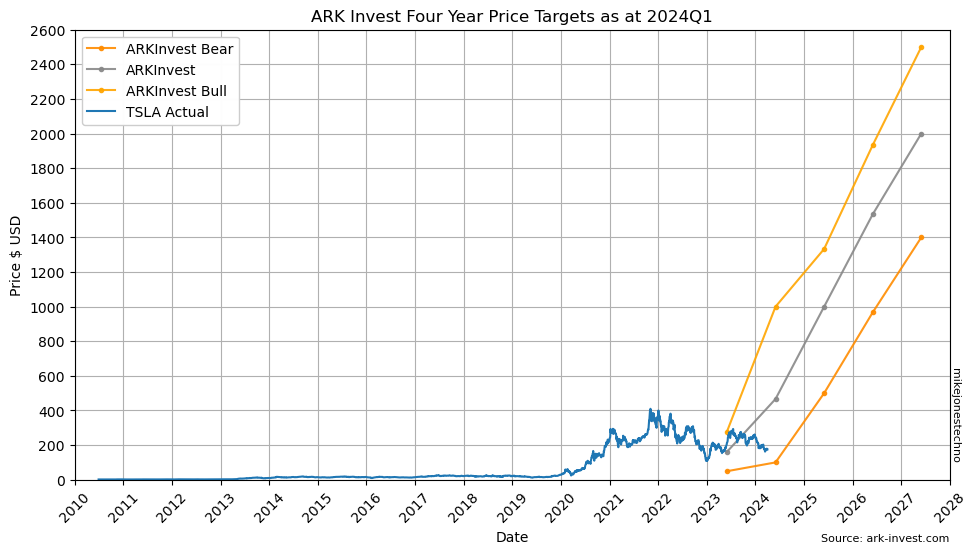

In [17]:
""" Extend simple chart with ARK price targets """
sx_symbol = 'TSLA'
data_column = 'Adj Close'
last_index = df_tsla[data_column].last_valid_index() # pandas timestamp

chart_params = {
    'chart_title': 'ARK Invest Four Year Price Targets as at ' + str(pd.Period(str(last_index), freq='Q') -1), 
    'chart_source': 'Source: ark-invest.com', 
    'y_label': 'Price $ USD', 
    'y_ticks': 200,
    'x_label': 'Date', 
    'x_ticks': 1,
    'top_limit': 2600,
    'data_column': data_column
}

standard_chart = StandardChart(**chart_params)
plt_std, colors = standard_chart.base_chart(df_tsla)

plt_std = plot_ark_forecast(plt_std, df_targets)   

legend = plt_std.legend(loc='best')
legend.get_frame().set_alpha(0.98)

plt_std.show()

Exponential growth often requires a long time horizon, the S&P 500 has a median annual growth rate of 12% and the exponential curve is clearly visible over a 50 year time horizon.

<a href="spx-prices.md"><img src="images/spx-prices_5_0.png" width="400"/> <img src="images/spx-prices_7_0.png" width="400"/></a>

Plotting the [SPX Prices on a logarithmic y-axis scale](spx-prices.md) produces a straight line up and to the right. 

Similarly, plotting the [TSLA Prices on a logarithmic y-axis scale](tsla-prices.md) produces a step line up and to the right. 

When evaluating long term exponential growth, a logarithmic scale helps visualize the long term trend.

On a logarithmic y-axis scale the ARK invest four year forecasts appear to be a regular continuation of the existing long term trend.

> ⚠ Disclaimer: _Not financial advice._ All content is for educational purposes only. No warranty or guarantee or forward looking statements of fit for purpose, etc;
do your own research.

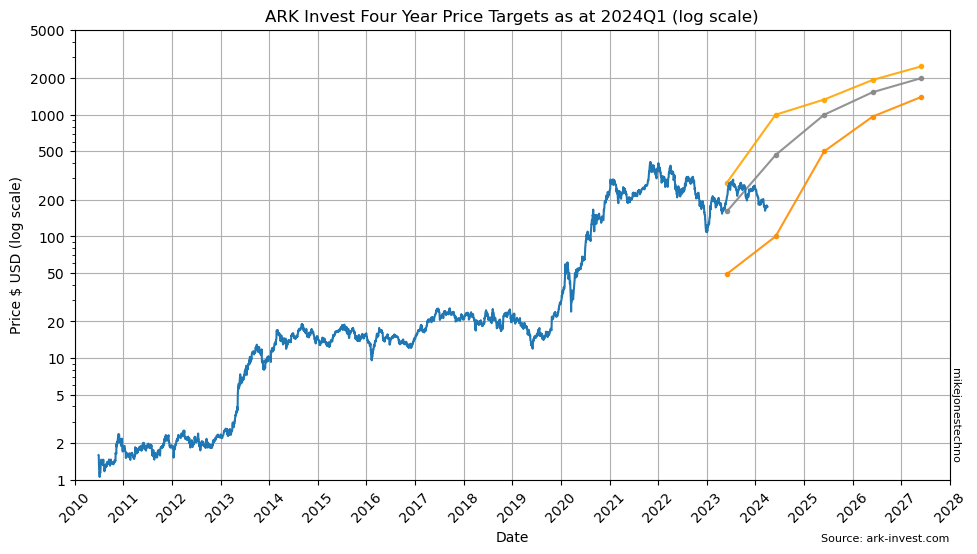

In [19]:
""" LOG SCALE with ARK price targets """

log_chart_params = chart_params.copy()
# remove parameters that are not relevant for log scale
log_chart_params.pop('y_ticks')
log_chart_params.pop('top_limit')
log_chart_params['chart_title'] = log_chart_params['chart_title'] + ' (log scale)'
log_chart_params['y_label'] = chart_params['y_label'] + ' (log scale)'
log_chart_params['y_ticks'] = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

log_chart = LogChart(**log_chart_params)
plt_log, colors = log_chart.base_chart(df_tsla)

plt_log = plot_ark_forecast(plt_log, df_targets)

plt_log.show()